# Sentiment Analysis using BERT


### Import Libraries and Set the intial variables

In [1]:
!pip install transformers


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

False

### Load the data

In [5]:
df = pd.read_csv("depressive_tweets_processed.csv",sep = '|', header = None, usecols = range(0,9))
df.columns = [3, "date", "time", "time-zone", "user", "tweet", 0, 1, 2]
df = df.drop([0, 1, 2, 3, "time-zone", "time", "date", "user"], axis = 1)
df['label'] = [1] * len(df['tweet']) # 1 cause these are all depressed tweets
df2_d = pd.read_csv("d_tweets.csv")
df2_d = df2_d[["tweet"]]
df2_d['label'] = [1] * len(df2_d['tweet'])

df2_nd = pd.read_csv("non_d_tweets.csv")
df2_nd = df2_nd[["tweet"]]
df2_nd['label'] = [0] * len(df2_nd['tweet'])
print(len(df2_nd['label']))
df = pd.concat([df2_d, df2_nd, df])
df.reset_index(inplace = True)
df['tweet'] = df['tweet'].astype(str)



4809


In [8]:
df = pd.read_csv("/content/positive_user.txt")
df = pd.concat([df, pd.read_csv("/content/negative_user.txt")])
temp = df.values



grouped = df.groupby('user')['text'].agg(list).reset_index()

# Extract the label for each user (assuming it's the same for all tweets by the same user)
grouped['label'] = df.groupby('user')['label'].first().values

# Rename columns to match your desired structure
grouped.columns = ['user', 'tweet', 'label']

# Create a new DataFrame with the desired structure
df = grouped[['user', 'tweet', 'label']]

# Display or use new_df as needed



We can see that the most relevant column for us is content and replyContent and the score as well.

In [ ]:
df.iloc[4].tweet

['@paulyhiggins (Originally written to Ellen Degeneres)',
 '@paulyhiggins Her friend calls this "Overcoming Depression with One Direction"',
 '@paulyhiggins Since she posted her story...things like her father walking out on her and her grandmother passing this week..',
 '@paulyhiggins please respond so i know that you are getting these &lt;/3',
 '@paulyhiggins shes a normal girl with a disease thats taking over :(',
 '@paulyhiggins she still very well can be suicidal on bad days',
 "@paulyhiggins She still hasn't pulled through this all the way",
 '@paulyhiggins Paul, help us with the cause :(',
 '@paulyhiggins pauly!!!!',
 "@1DPaparazzis can't wait for it to come out in the us!!!! ARG!!",
 '@Mikaylamendoza5 @Louis_Tomlinson awh man its not out in the us yet! :(',
 '@InPainForPayne_ @ashpinc oh good to hear (: haha',
 '@ashpinc @InPainForPayne_ wait what happened?',
 'RT @Tracking1D: “@1DUpdatesARG_: Friendly reminder that this is how Niall recorded the album.. http://t.co/iX4UrXBw”',


In [ ]:
# Let's have a look at the class balance.
sns.countplot(df.label)
plt.xlabel('review score');

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7b60630f89d0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7b6062f73be0> (for post_execute):


KeyboardInterrupt: 

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now.

* 0 - negative
* 1 - neutral
* 2 - positive

In [9]:
# Plot the distribution
class_names = ['not depressed', 'depressed']


## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word.

In [10]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [18]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=5000)
    token_lens.append(len(tokens))


Text(0.5, 0, 'Token count')

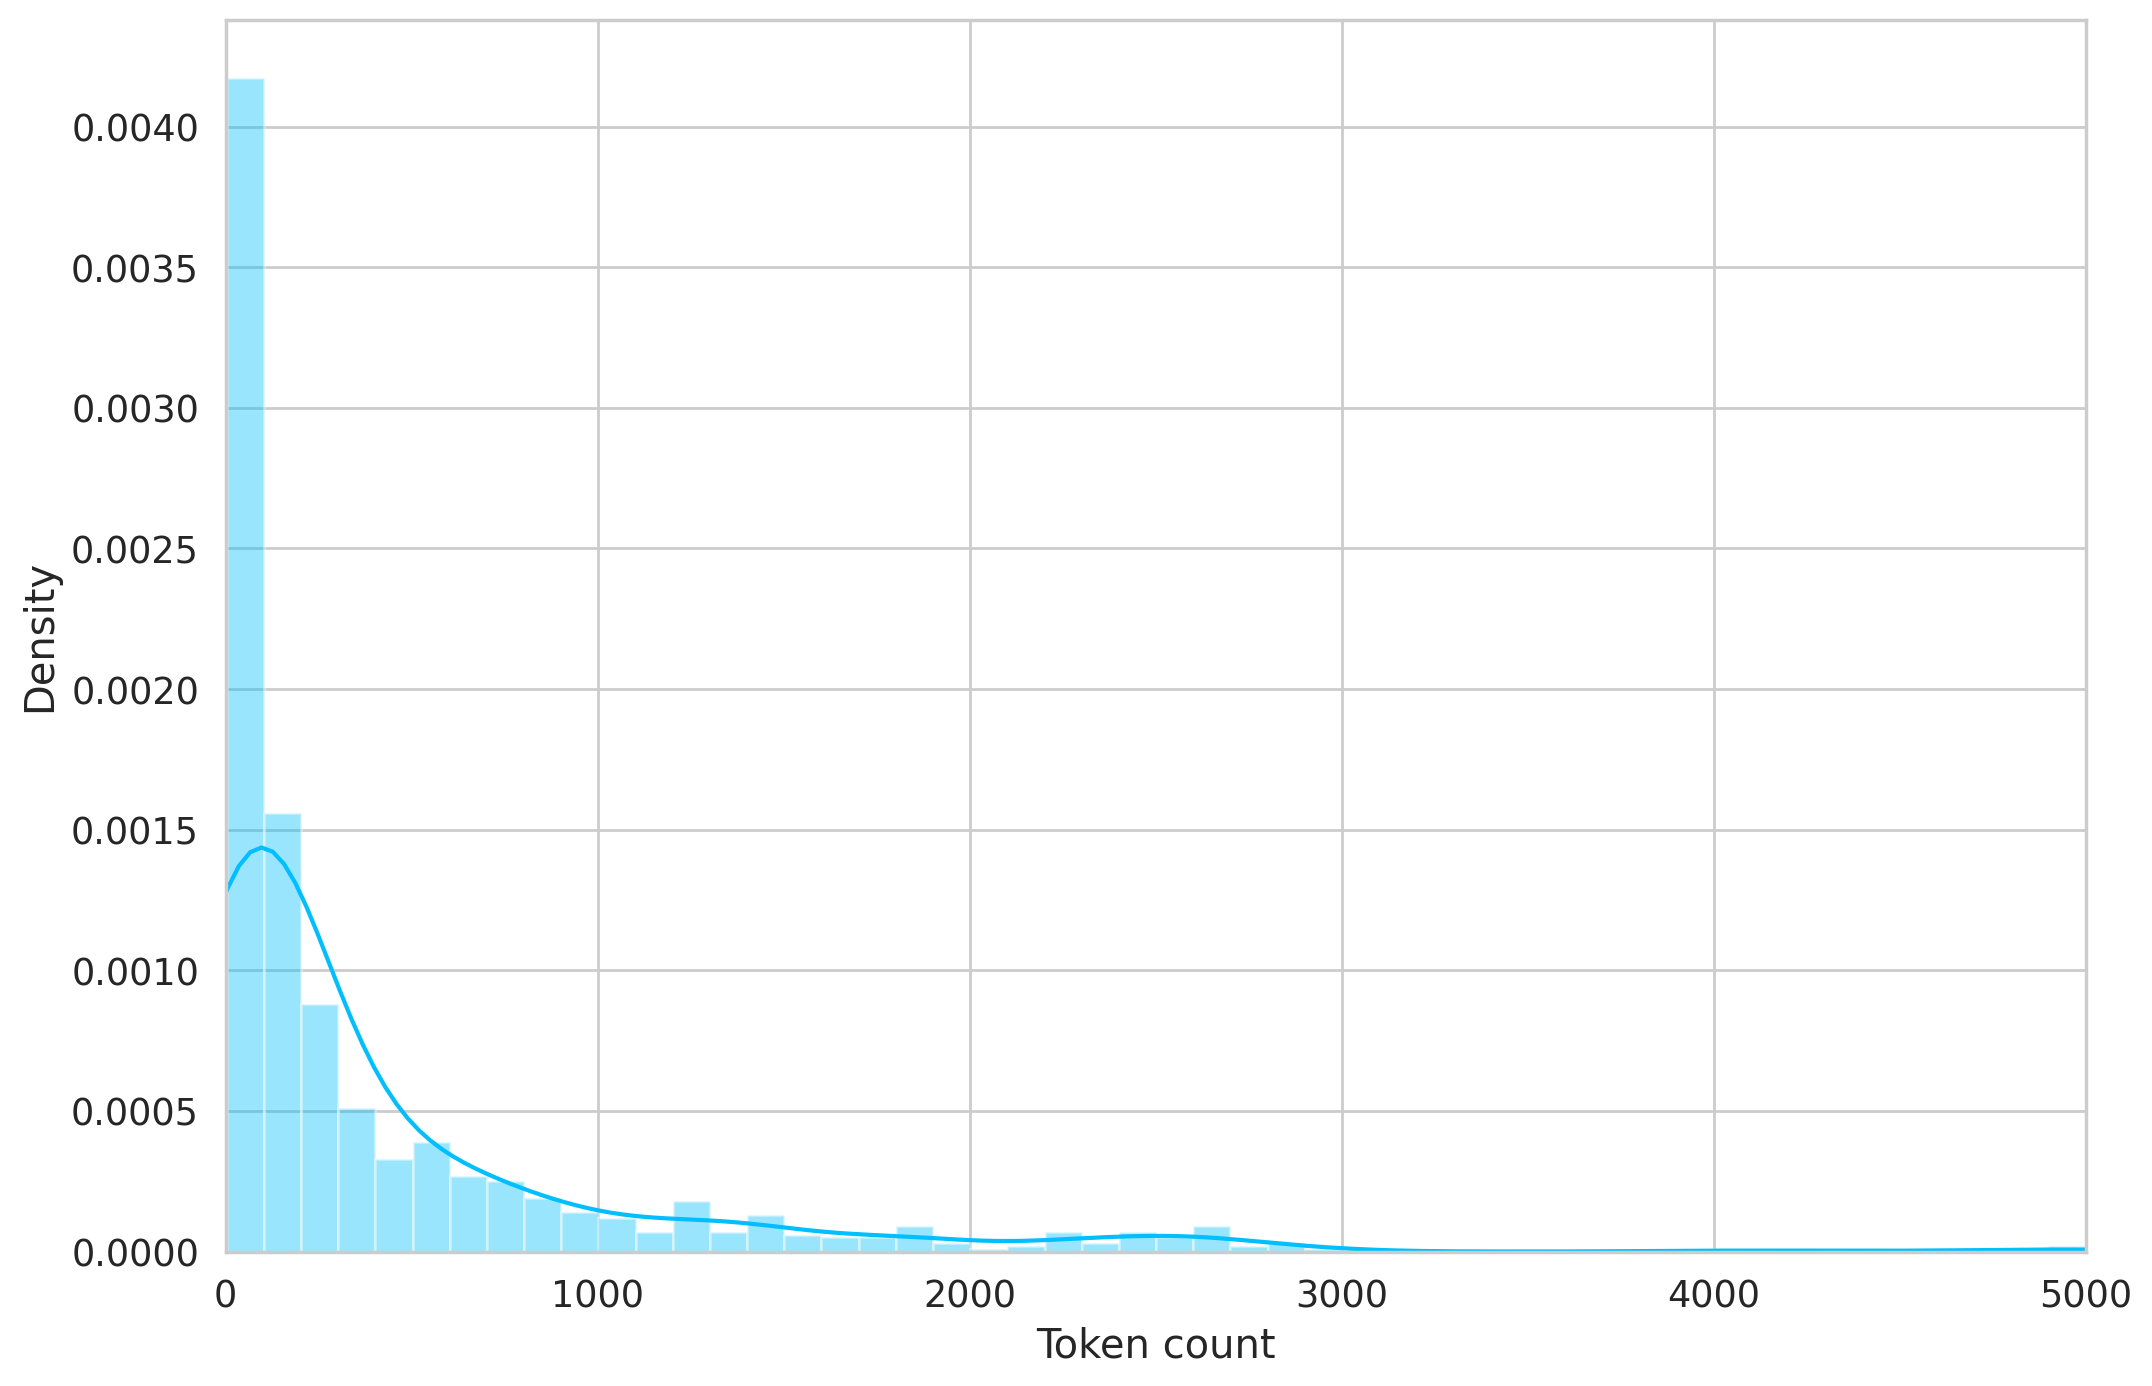

In [19]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 5000]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [20]:
MAX_TWEETs = 5000
MAX_LEN = 160

In [21]:
tweets = []

for x in df['tweet'].values:
  temp = x
  if len(temp) < MAX_TWEETs:

    temp.extend([""] *( MAX_TWEETs - len(temp) ))

  tweets.append(temp)
df['tweet'] = tweets


### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [22]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned


        encoding = [self.tokenizer.encode_plus(x,add_special_tokens=True,max_length=self.max_len,return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,return_tensors='pt',) for x in review]
        if(len(encoding) > MAX_TWEETs):
          encoding = encoding[0:MAX_TWEETs + 1]


        return {
            'review_text': review,
            'input_ids': [x['input_ids'].flatten() for x in encoding],
            'attention_mask': [x['attention_mask'].flatten() for x in encoding],
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [23]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(800, 3) (100, 3) (100, 3)


Create a dataloader to release data in batches.

In [24]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [25]:
# Create train, test and val data loaders
BATCH_SIZE = 2
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [26]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())



dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [27]:
print(data['input_ids'][0].shape)
print(data['attention_mask'][0].shape)
print(data['targets'][0].shape)

torch.Size([2, 160])
torch.Size([2, 160])
torch.Size([])


In [ ]:
data

{'review_text': ['[\'Also not restarting the counter, the first three still count.\\r\\n\\r\\n4. My record for time spent not talking to anybody is about nine days.\', \'I think the Pellinores are trying to make me incriminate myself. But alright, game on. The lies are still in.\', \'@MedrinaKamaar It seems like such a good idea until you have to get on a rollercoaster.\', "Screw it, reposting with the image. I -might- still lie on every multiple of a random number, we\'ll see. https://t.co/EPx5SWIUUK", "@MedrinaKamaar Wasn\'t too bad, I think I was happier being away from them anyway.", "@MedrinaKamaar That happened, like... three times to me.\\r\\n\\r\\nMy parents didn\'t like me. Easy way to cut 33% of holiday expenses.", \'Hmm, wonder what I did as a misstep. Was it not using the superfluous picture, throwing in the lying caveat, or just being me?\', \'@The_Mereland ...How even the fuck.\', \'@The_Mereland ...Jesus christ how did you get nine that quickly\', \'3. I had a pet spider

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [28]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [29]:
t = torch.Tensor([1, 2, 3])
out = t.cpu().detach().numpy()

In [30]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(input_size=768*160, hidden_size=50, num_layers=1, batch_first=True)
        self.out = nn.Linear(self.lstm.hidden_size, 1)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
      pooled_output = np.empty((MAX_TWEETs + 1, BATCH_SIZE, 160, 768))
      for x in range(0 , len(input_ids)):
        output = self.bert(input_ids=input_ids[x],attention_mask=attention_mask[x],return_dict=False)
        output = self.drop(output[0])
        pooled_output[x] = output.cpu().detach().numpy()
      pooled_output = np.float32(pooled_output)
      lstmOut = self.lstm(torch.from_numpy(pooled_output.reshape(2, MAX_TWEETs + 1, 160*768)).cuda())
      realLSTMOut = np.empty((BATCH_SIZE, 50))
      lstmOut = lstmOut[0].cpu().detach()
      for i in range(0, BATCH_SIZE):
        realLSTMOut[i] = lstmOut[i][MAX_TWEETs]
      realLSTMOut = np.float32(realLSTMOut)
      linear = self.out(torch.from_numpy(realLSTMOut).cuda())
      return torch.sigmoid(linear)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [31]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [32]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [33]:
# Number of iterations
EPOCHS = 4

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [34]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = [x.to(device) for x in d["input_ids"]]
        attention_mask = [x.to(device) for x in d["attention_mask"]]
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs = torch.reshape(outputs, (-1, 1)).float()
        targets = torch.reshape(targets, (-1, 1)).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs == targets)
        losses.append(loss.item())
        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            outputs = torch.reshape(outputs, (-1, 1)).float()
            targets = torch.reshape(targets, (-1, 1)).float()

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs == targets)
            losses.append(loss.item())
            print("it")
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [36]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------


In [ ]:
df

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

In [ ]:
history

defaultdict(list, {})

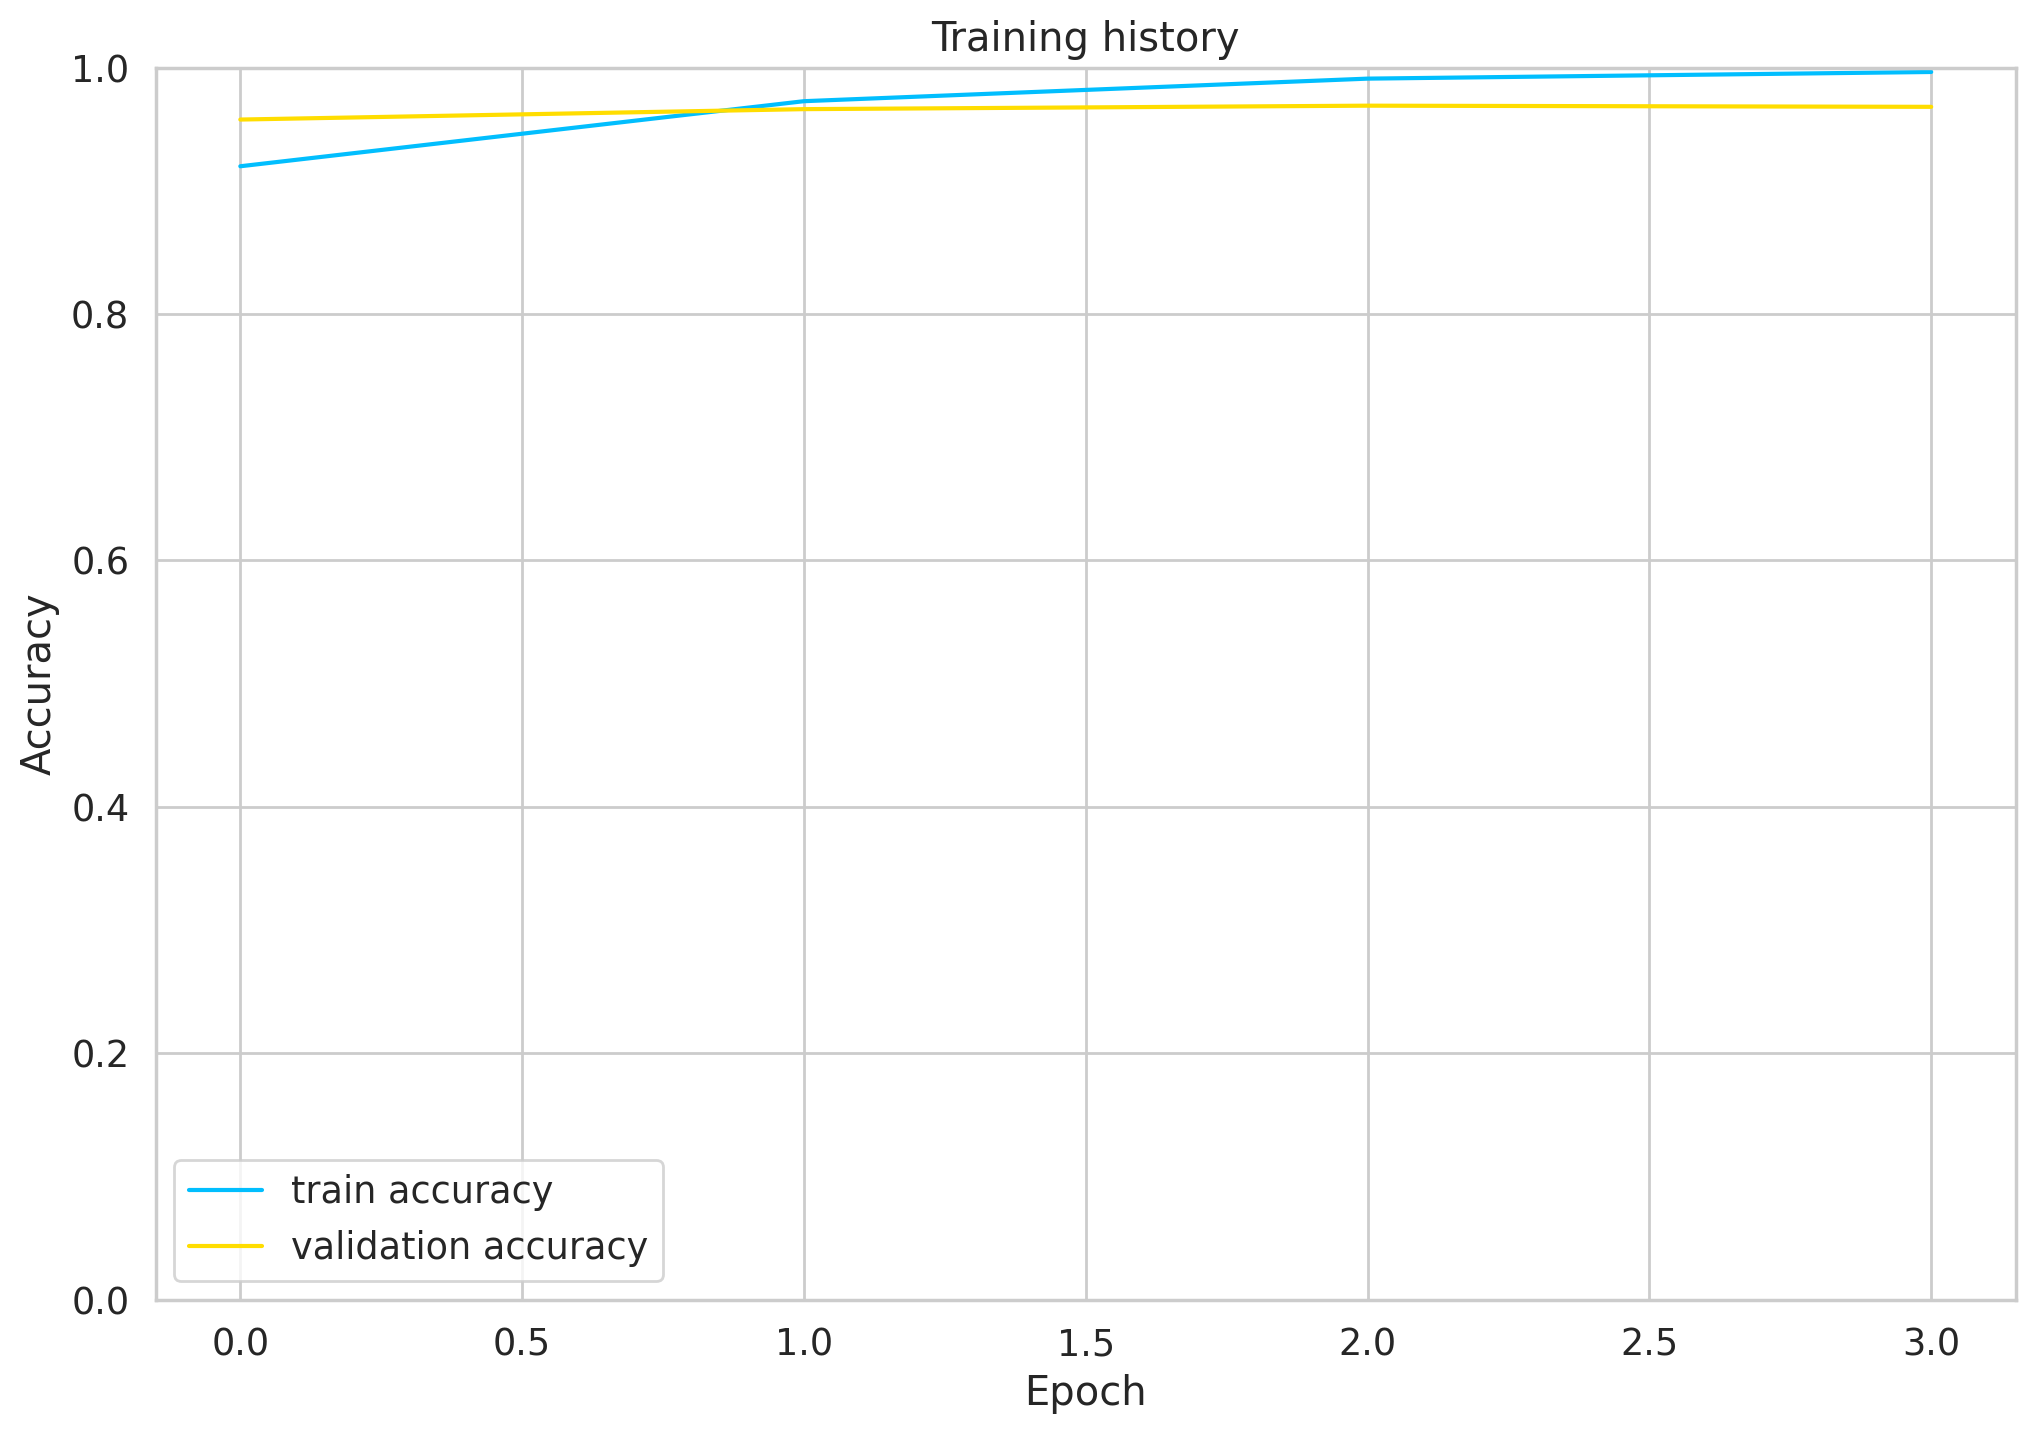

In [ ]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9605633802816902

In [ ]:
Ones = 0
Zeros = 0
test
for x in test_data_loader.dataset.targets:
  if x ==0:
    Zeros+=1
  else:
    Ones+=1
print("0", Zeros, "1", Ones)

0 470 1 595


In [ ]:
test_data_loader.dataset.targets

array([1, 1, 1, ..., 0, 0, 0])

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.95      0.96      0.96       470
    depressed       0.97      0.96      0.96       595

     accuracy                           0.96      1065
    macro avg       0.96      0.96      0.96      1065
 weighted avg       0.96      0.96      0.96      1065



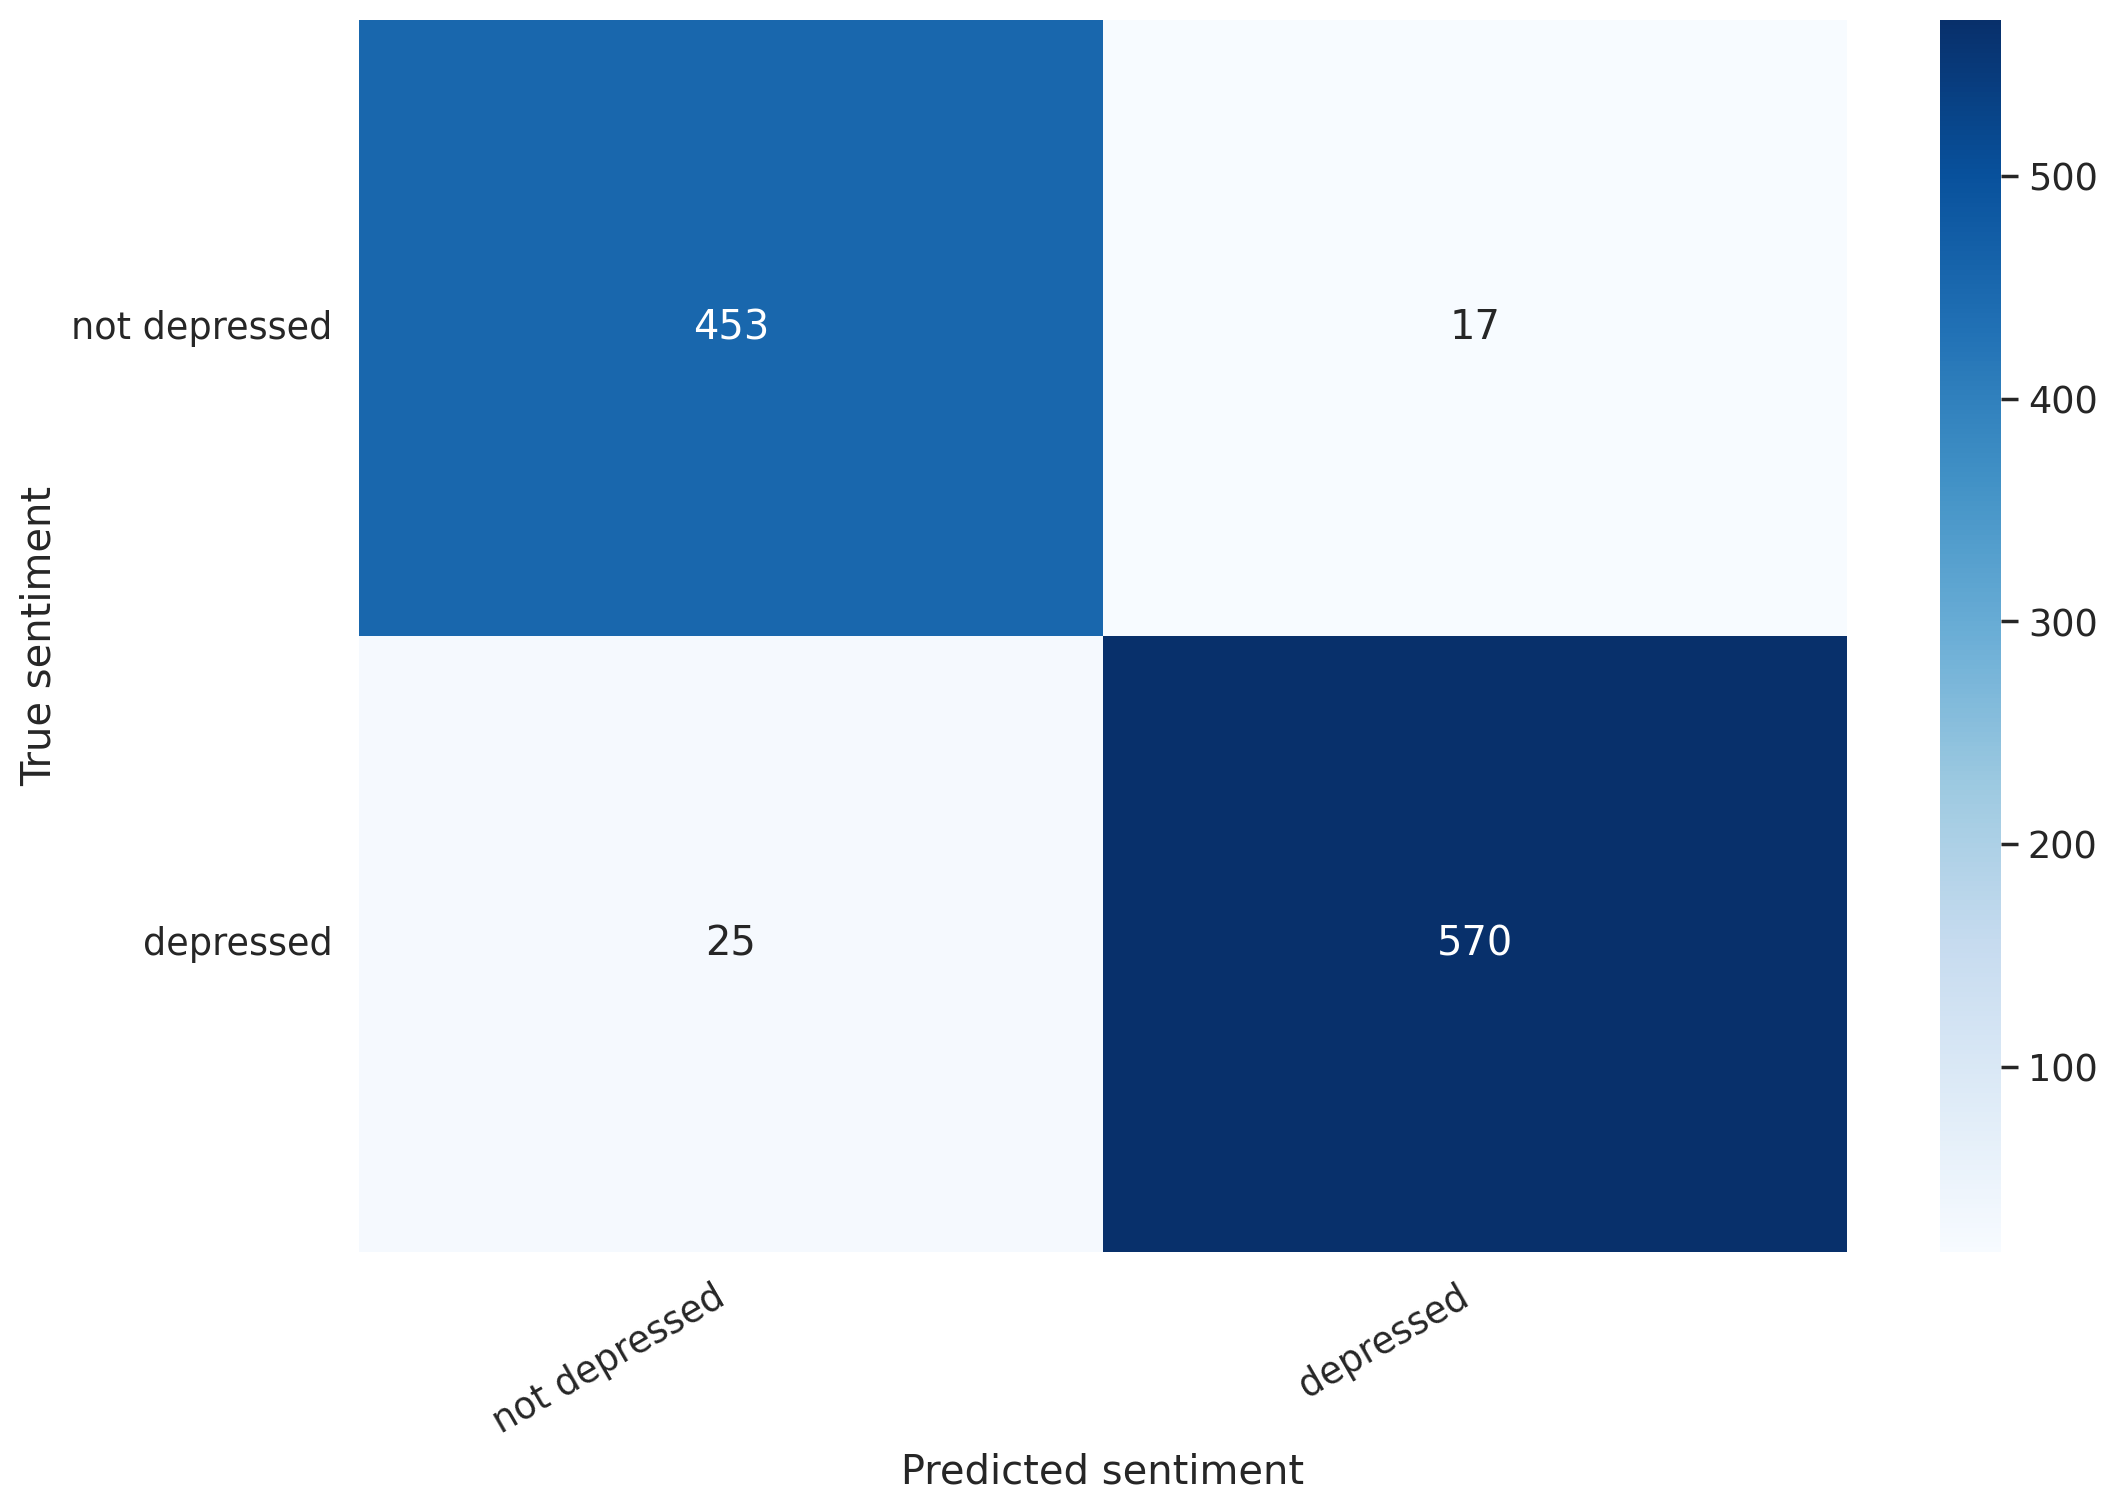

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [ ]:
review_text = "I have depression h"

In [ ]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I have depression sadly
Sentiment  : depressed


In [ ]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
model = torch.load("model.pt", map_location=torch.device('cpu'))

print(type(model))

<class 'collections.OrderedDict'>


In [ ]:

model = SentimentClassifier(len(class_names))
model.load_state_dict(test)



<All keys matched successfully>